# Loading modules

In [1]:
import itertools
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import load_breast_cancer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from irls.irls import LogisticRegression

SEED = 123

# Dataset - Breast Cancer

In [2]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

All variables are numeric.

In [3]:
X.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

As we can see, we don't have any missing values to deal with.

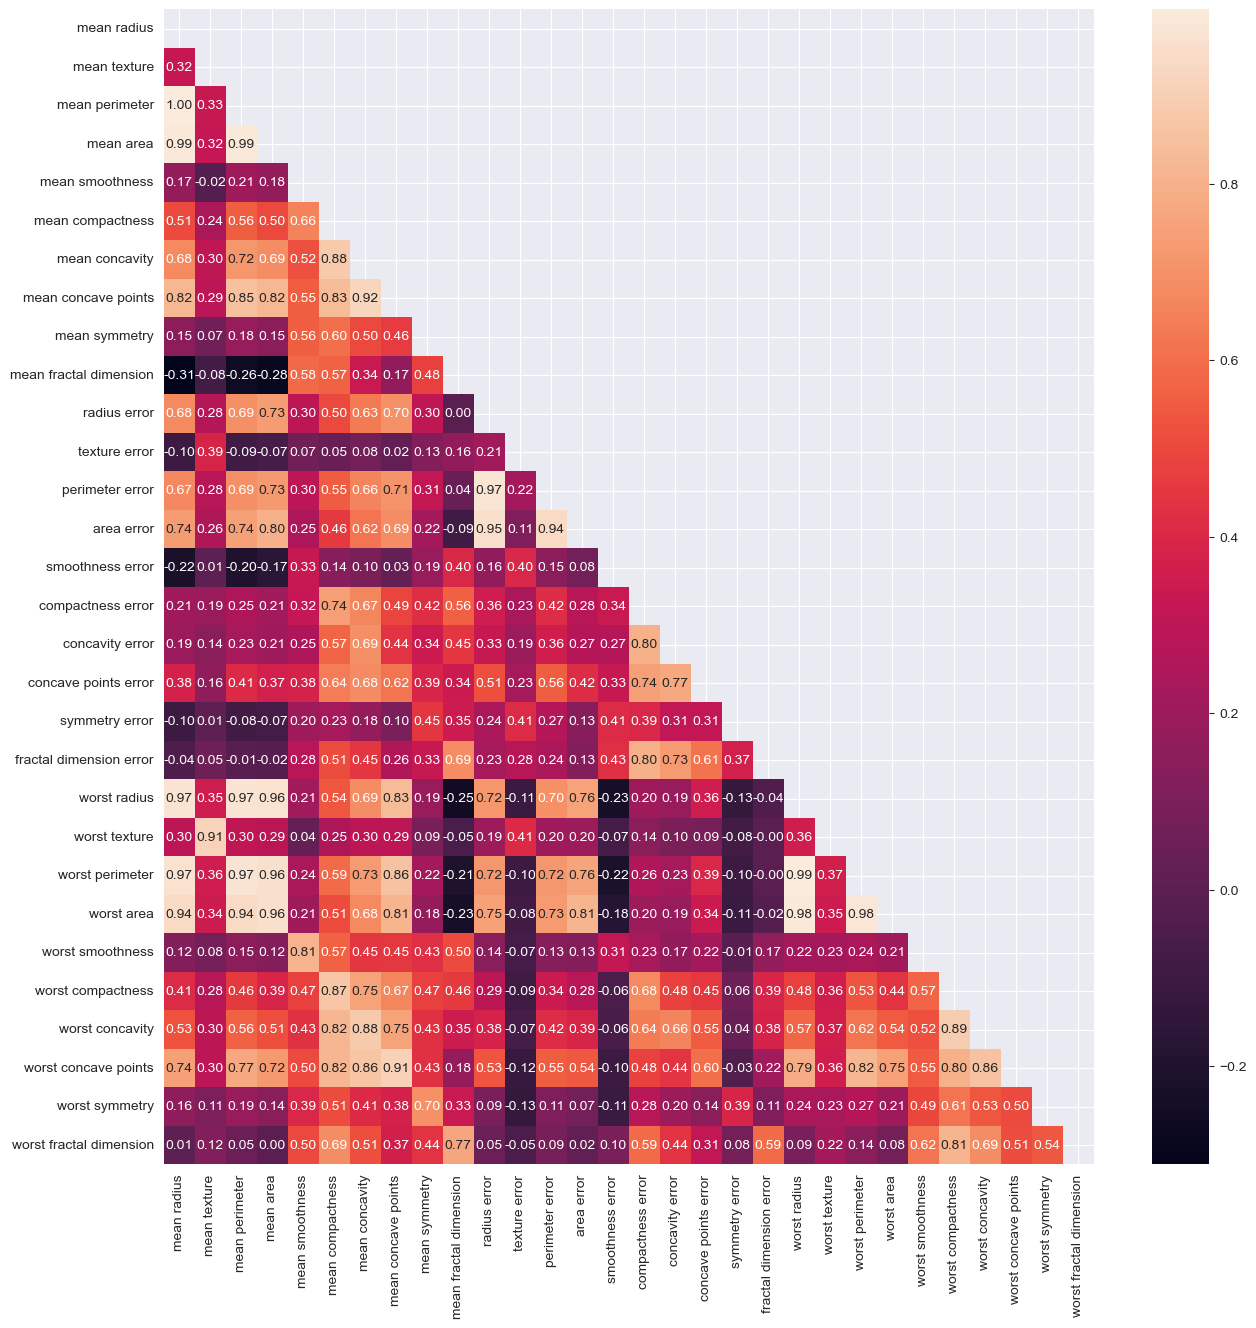

In [4]:
plt.figure(figsize=(15, 15))
cor = X.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor, mask=mask, annot=True, fmt='.2f')
plt.show()

We can read from the heatmap which variables are correlated and then remove one variable from each pair of correlated variables. But we will use VIF values to chose variables which are not linearly dependent.

In [5]:
def get_proper_columns(data):
    data_loc = add_constant(data)
    columns = data_loc.columns.tolist()
    while True:
        vif = pd.DataFrame([{"column": columns[i], "vif": variance_inflation_factor(data_loc.values, i)} for i in
                            range(data_loc.shape[1])])
        vif = vif.loc[vif.column != "const"].max()
        if vif["vif"].item() >= 10:
            columns.remove(vif["column"])
            data_loc = data_loc[columns]
        else:
            columns.remove("const")
            return columns

In [6]:
y.value_counts(normalize=True)

1    0.627417
0    0.372583
Name: target, dtype: float64

It should be noted that the dataset has an imbalanced target variable, with a significantly higher number of observations belonging to the benign class than the malignant class.

# Evaluation of models
## Scores

In [7]:
pipe_knn = Pipeline([
    ("transformer", StandardScaler()),
    ("knn", KNeighborsClassifier())
]
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
result = []
for i, (train_indexes, test_indexes) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes].values
    X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes].values
    columns = get_proper_columns(X_train)
    X_train = X_train[columns].values
    X_test = X_test[columns].values
    for name, model in [("QDA", QDA()), ("LDA", LDA()),
                        ("Logistic Regression (without interactions)", LogisticRegression(optimizer="IRLS")),
                        ("Logistic Regression (with interactions)", LogisticRegression(optimizer="IRLS")),
                        ("KNN", pipe_knn)]:
        model_to_fit = clone(model)
        fitted_model = model_to_fit.fit(X_train, y_train) if name != "Logistic Regression (with interactions)" else \
            model_to_fit.fit(X_train, y_train,
                             interactions=np.stack([i for i in itertools.combinations(range(len(columns)), 2)]))
        y_proba = fitted_model.predict_proba(X_test)[:,
                  1] if not name.startswith("Logistic Regression") else fitted_model.predict_proba(X_test)
        y_pred = fitted_model.predict(X_test)
        res = {
            "model": name,
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced accuracy": balanced_accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "roc auc": roc_auc_score(y_test, y_proba),
            "split": i,
            "number of variables": len(columns)
        }
        result.append(res)

result_df = pd.DataFrame(result)
result_df

,model,accuracy,balanced accuracy,F1,roc auc,split,number of variables
0,QDA,0.894737,0.880519,0.916667,0.958442,0,7
1,LDA,0.877193,0.840909,0.909091,0.975325,0,7
2,Logistic Regression (without interactions),0.912281,0.894805,0.931507,0.974026,0,7
3,Logistic Regression (with interactions),0.912281,0.894805,0.931507,0.932468,0,7
4,KNN,0.929825,0.917532,0.944444,0.991558,0,7
5,QDA,0.859649,0.851948,0.885714,0.932468,1,7
6,LDA,0.877193,0.849351,0.906667,0.961039,1,7
7,Logistic Regression (without interactions),0.912281,0.903247,0.929577,0.975325,1,7
8,Logistic Regression (with interactions),0.894737,0.897403,0.911765,0.964935,1,7
9,KNN,0.859649,0.860390,0.882353,0.917532,1,7


## Plot

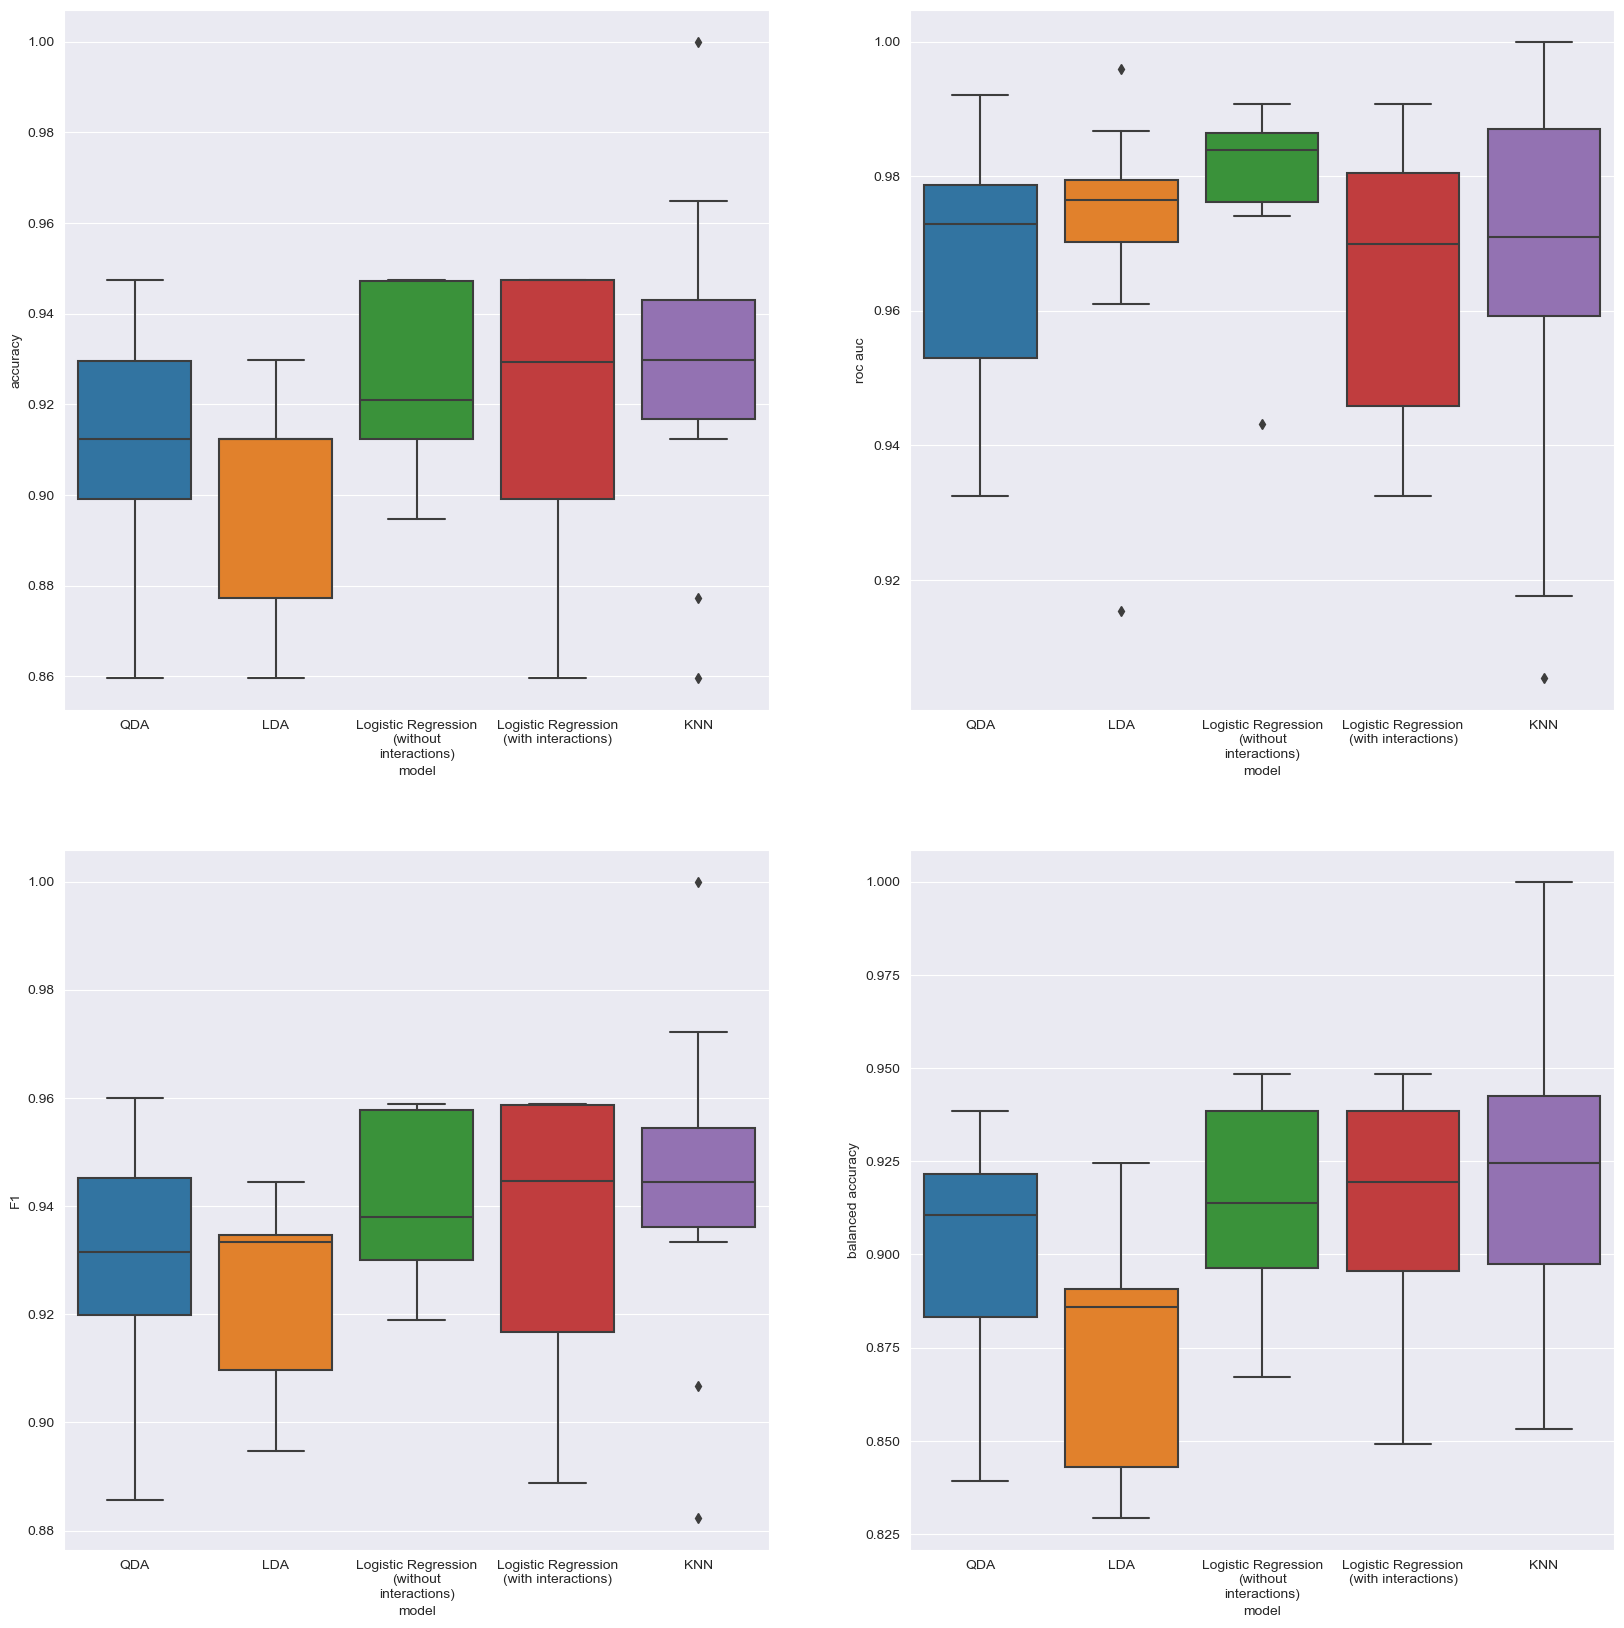

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
wrapped_labels = [ '\n'.join(textwrap.wrap(label, 20)) for label in result_df.model.unique().tolist()]

sns.boxplot(result_df, x="model", y="accuracy", ax=axes[0][0])
axes[0][0].set_xticklabels(wrapped_labels)
sns.boxplot(result_df, x="model", y="roc auc", ax=axes[0][1])
axes[0][1].set_xticklabels(wrapped_labels)
sns.boxplot(result_df, x="model", y="F1", ax=axes[1][0])
axes[1][0].set_xticklabels(wrapped_labels)
sns.boxplot(result_df, x="model", y="balanced accuracy", ax=axes[1][1])
axes[1][1].set_xticklabels(wrapped_labels)
plt.show()

## Number of variables

In [9]:
variables = result_df[["split", "number of variables"]].drop_duplicates()
variables

,split,number of variables
0,0,7
5,1,7
10,2,7
15,3,7
20,4,7
25,5,7
30,6,7
35,7,7
40,8,7
45,9,7
